# <font size="7"> **Assignment-7**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [28]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 7

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [29]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [30]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [31]:
# TRAIN-VALIDATION SPLIT and STANDARDIZATION
X_train, X_valid, y_train, y_valid = train_test_split(
    X_full, y_full, test_size=0.3, random_state=GROUP_NUMBER
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)
y_train = torch.FloatTensor(y_train)
y_valid = torch.FloatTensor(y_valid)


In [32]:
# MLP ARCHITECTURE
class MLP:
    def __init__(self, input_dim=2, hidden_dim=16, output_dim=1):
        self.W1, self.b1 = self.init_layer(input_dim, hidden_dim)
        self.W2, self.b2 = self.init_layer(hidden_dim, hidden_dim)
        self.W3, self.b3 = self.init_layer(hidden_dim, hidden_dim)
        self.W4, self.b4 = self.init_layer(hidden_dim, output_dim)

        self.params = [
            self.W1, self.b1,
            self.W2, self.b2,
            self.W3, self.b3,
            self.W4, self.b4
        ]

    def init_layer(self, in_dim, out_dim):
        std = np.sqrt(2.0 / in_dim)
        W = torch.randn(in_dim, out_dim) * std
        b = torch.zeros(out_dim)
        W.requires_grad_()
        b.requires_grad_()
        return W, b

    def forward(self, X):
        A1 = torch.relu(X @ self.W1 + self.b1)
        A2 = torch.relu(A1 @ self.W2 + self.b2)
        A3 = torch.relu(A2 @ self.W3 + self.b3)
        out = torch.sigmoid(A3 @ self.W4 + self.b4)
        return out

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


In [33]:
# MANUAL BCE + ACCURACY
class Metrics:
    @staticmethod
    def binary_cross_entropy(y_hat, y):
        eps = 1e-15
        y_hat = torch.clamp(y_hat, eps, 1 - eps)
        return -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat)).mean()

    @staticmethod
    def accuracy(y_pred, y):
        preds = (y_pred >= 0.55).float()
        return (preds == y).float().mean().item()


In [34]:
# MANUAL SGD
class Trainer:
    def __init__(self, model, lr=0.01, epochs=10000):
        self.model = model
        self.lr = lr
        self.epochs = epochs

        self.train_loss = []
        self.valid_loss = []
        self.train_acc = []
        self.valid_acc = []

    def fit(self, X_train, y_train, X_valid, y_valid):
        for epoch in range(self.epochs + 1):

            # Forward
            y_pred = self.model.forward(X_train)
            loss = Metrics.binary_cross_entropy(y_pred, y_train)

            # Backward
            self.model.zero_grad()
            loss.backward()

            # Manual SGD
            with torch.no_grad():
                for p in self.model.params:
                    p -= self.lr * p.grad

            # Metrics
            with torch.no_grad():
                self.train_loss.append(loss.item())
                self.train_acc.append(Metrics.accuracy(y_pred, y_train))

                val_pred = self.model.forward(X_valid)
                val_loss = Metrics.binary_cross_entropy(val_pred, y_valid)

                self.valid_loss.append(val_loss.item())
                self.valid_acc.append(Metrics.accuracy(val_pred, y_valid))

            if epoch % 1000 == 0:
                print(f"Epoch {epoch:5d} | "
                      f"Train Loss: {self.train_loss[-1]:.4f} | "
                      f"Val Loss: {self.valid_loss[-1]:.4f}")
                print(f"Epoch {epoch:5d} | "
                      f"Train Acc: {self.train_acc[-1]:.4f} | "
                      f"Val Acc: {self.valid_acc[-1]:.4f}\n")


In [35]:
# GDC DASHBOARD
class GDCVisualizer:
    @staticmethod
    def plot_dashboard(trainer, model, X_valid, y_valid, scaler):

        plt.figure(figsize=(16, 5))

        # Loss Plot
        plt.subplot(1, 3, 1)
        plt.plot(trainer.train_loss, label="Train")
        plt.plot(trainer.valid_loss, label="Validation")
        plt.title("System Error Trajectory")
        plt.legend()

        # Accuracy Plot
        plt.subplot(1, 3, 2)
        plt.plot(trainer.train_acc, label="Train")
        plt.plot(trainer.valid_acc, label="Validation")
        plt.title("Integrity Check")
        plt.legend()

        # Decision Boundary
        xx, yy = torch.meshgrid(
            torch.linspace(-5, 5, 200),
            torch.linspace(-5, 5, 200),
            indexing="ij"
        )

        grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)
        grid_scaled = torch.FloatTensor(scaler.transform(grid.numpy()))

        with torch.no_grad():
            zz = model.forward(grid_scaled).reshape(xx.shape)

        plt.subplot(1, 3, 3)
        cf = plt.contourf(xx, yy, zz, levels=50, cmap="coolwarm", alpha=0.7)
        plt.contour(xx, yy, zz, levels=[0.5], colors="black", linewidths=2)

        X_valid_rescaled = scaler.inverse_transform(X_valid.numpy())
        plt.scatter(X_valid_rescaled[:, 0], X_valid_rescaled[:, 1],
                    c=y_valid.squeeze(), s=6, cmap="coolwarm")

        plt.title("Geospatial Threat Map")
        plt.colorbar(cf, label="Radiation Probability")
        plt.tight_layout()
        plt.show()


Epoch     0 | Train Loss: 0.9921 | Val Loss: 0.9223
Epoch     0 | Train Acc: 0.3986 | Val Acc: 0.4500

Epoch  1000 | Train Loss: 0.5999 | Val Loss: 0.6163
Epoch  1000 | Train Acc: 0.6081 | Val Acc: 0.5789

Epoch  2000 | Train Loss: 0.5434 | Val Loss: 0.5556
Epoch  2000 | Train Acc: 0.6038 | Val Acc: 0.6033

Epoch  3000 | Train Loss: 0.4896 | Val Loss: 0.4989
Epoch  3000 | Train Acc: 0.7124 | Val Acc: 0.7222

Epoch  4000 | Train Loss: 0.4439 | Val Loss: 0.4511
Epoch  4000 | Train Acc: 0.7762 | Val Acc: 0.7800

Epoch  5000 | Train Loss: 0.4035 | Val Loss: 0.4102
Epoch  5000 | Train Acc: 0.8576 | Val Acc: 0.8500

Epoch  6000 | Train Loss: 0.3601 | Val Loss: 0.3678
Epoch  6000 | Train Acc: 0.8981 | Val Acc: 0.8867

Epoch  7000 | Train Loss: 0.3259 | Val Loss: 0.3356
Epoch  7000 | Train Acc: 0.9152 | Val Acc: 0.9011

Epoch  8000 | Train Loss: 0.3067 | Val Loss: 0.3200
Epoch  8000 | Train Acc: 0.9229 | Val Acc: 0.9089

Epoch  9000 | Train Loss: 0.2958 | Val Loss: 0.3119
Epoch  9000 | Train A

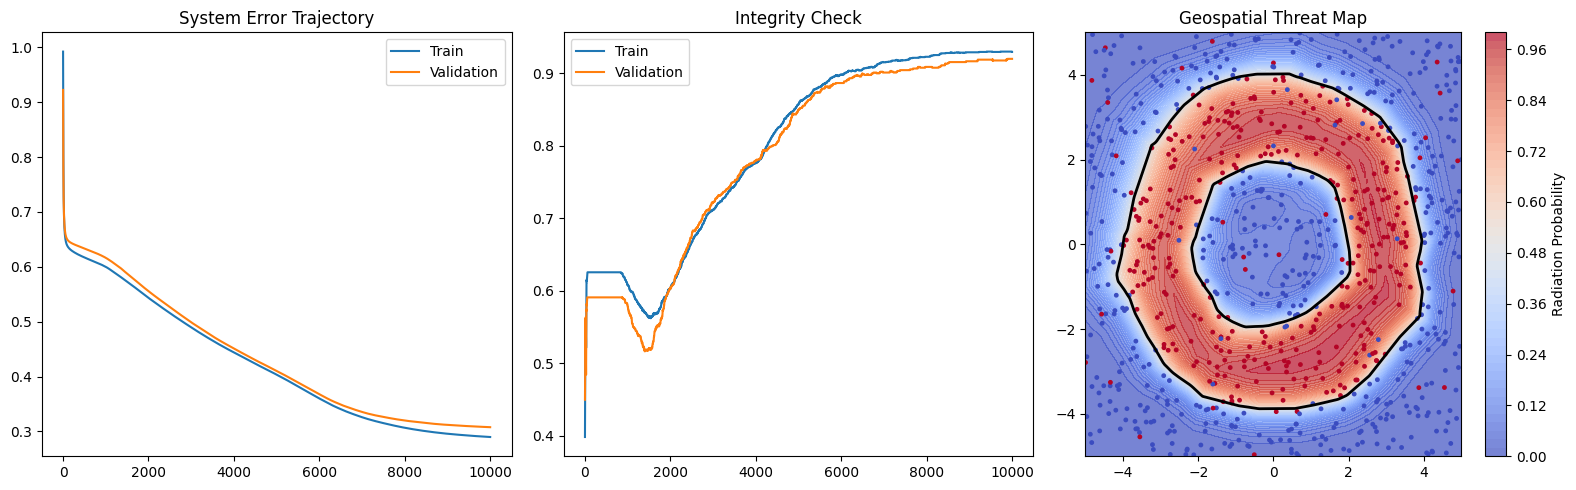

Final Training Accuracy: 0.9295
Final Validation Accuracy: 0.9200


In [36]:
# TRAIN + VISUALIZE
model = MLP()
trainer = Trainer(model, lr=0.01, epochs=10000)
trainer.fit(X_train, y_train, X_valid, y_valid)

GDCVisualizer.plot_dashboard(trainer, model, X_valid, y_valid, scaler)

print(f"Final Training Accuracy: {trainer.train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {trainer.valid_acc[-1]:.4f}")
